In [1]:
import json
#from fastdtw import fastdtw
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
import itertools
import sklearn

In [46]:
with open('tmp/cuysq_6000_preserve3b_learnedseenlongd.json') as f:#('tmp/fogdm_7000_testingnaiveseen.json') as f:
    statetracelearned = json.load(f)['data'][1::]
print(len(statetracelearned[0]),len(statetracelearned))

2400 5


In [47]:
sensornames = ['S'+str(idx) for idx in range(16)]
run = 3
epoch=0
startday = epoch*30
periods = 8#in three hours 8 periods make a full day
duration =300#days
#
"""
run=2
startday = 39
periods = 8#in three hours 8 periods make a full day
duration =5#days
#"""
select = [startday*periods,(startday+duration)*periods]
def create_trace(data):
    t = {}
    for s in sensornames:
        t[s] = np.asarray([i[s] for i in data])#[select[0]:select[1]]])
    return t
alltraces = create_trace([i for j in statetracelearned[0:5] for i in j])

In [48]:
def extract_feature(t):
    is_active = lambda i:i[0]==0 and i[1]>0
    is_idle = lambda i:i[0]==1 and i[1]>0
    is_sleep = lambda i:i[0]==2 and i[1]>0
    is_dead = lambda i:i[1]==0
    counter = lambda data, f: len([i for i in data if f(i)])
    return [counter(t, f) for f in [is_active,is_idle,is_sleep,is_dead]]
def extract_timesensitive_feature(t):
    sorted_by_time = sorted(t, key=lambda i:i[3])
    grouped_by_time = itertools.groupby(sorted_by_time, key=lambda i:i[3])
    features_by_time = {k:extract_feature(list(v)) for k,v in grouped_by_time}
    keys = sorted(list(set([k for k in features_by_time])))
    return np.asarray(list(itertools.chain(*[features_by_time[k] for k in keys])))
def extract_daynight_feature(t):
    sorted_by_time = sorted(t, key=lambda i:int(i[3]) in [1,2,3])
    grouped_by_time = itertools.groupby(sorted_by_time, key=lambda i:int(i[3]) in [1,2,3])
    features_by_time = {k:extract_feature(list(v)) for k,v in grouped_by_time}
    keys = sorted(list(set([k for k in features_by_time])))
    return np.asarray(list(itertools.chain(*[features_by_time[k] for k in keys])))    
#extract_timesensitive_feature(traces['S1'])


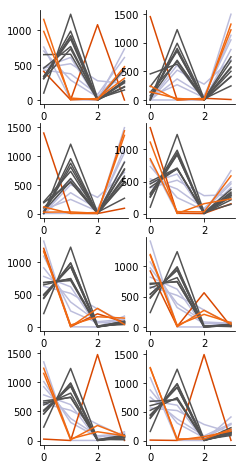

In [69]:
#for run in statetracelearned:
groups = {'worker':['S0','S6','S5','S4','S3'],
              'idler':['S12','S10','S9','S15']+['S11','S14','S7','S13'],
              'saver':['S8','S1'],
              'ubersaver':['S2']}#,'S2']}
colorkey = {'worker':["#bcbddc"]
                ,'idler':["#525252"]
                ,'saver':["#f16913"]
                ,'ubersaver':["#d94801"]}
fig, axarr = plt.subplots(4,2)
fig.set_size_inches(3.5,8)
for idx, ax in enumerate(itertools.chain(*axarr)):
    for g, sensors in groups.items():
        for e,s in enumerate(sensors):
            feature = extract_timesensitive_feature(alltraces[s])
            #if g=='worker':
            zindex = 100 if g=='saver' else 0
            if g in ['idler','worker','saver','ubersaver']:
                ax.plot(feature[idx*4:idx*4+4], label=s, color=colorkey[g][0], zorder=zindex)
sns.despine()

In [32]:
def feature_to_3d(feature, number_aggregated = 1):
    scale = 300*number_aggregated
    xs = [feature[2+(4*t)]/scale for t in range(8)]
    ys = [feature[1+(4*t)]/scale for t in range(8)]
    zs = [feature[3+(4*t)]/scale for t in range(8)]
    return xs,ys,zs
def feature_2d_all(feature,number_aggregated = 1):
    scale = 300*number_aggregated
    actives = [feature[0+(4*t)]/scale for t in range(8)]
    idles = [feature[1+(4*t)]/scale for t in range(8)]
    standbys= [feature[2+(4*t)]/scale for t in range(8)]
    offs = [feature[3+(4*t)]/scale for t in range(8)]
    return [np.mean(feature) for feature in [actives,idles,standbys,offs]]

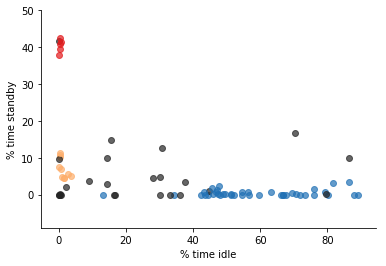

In [64]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax =fig.add_subplot(111)
def plot2d(data,ax,aggregated = 1):
    groups = {'worker':['S0','S5','S4','S6','S3'],
              'idler':['S12','S10','S9','S15']+['S11','S14','S7','S13'],
              'saver':['S8','S1'],
              'ubersaver':['S2']}#,'S2']}
    colorkey = {'worker':["#252525","#000000"]
                ,'idler':["#2171b5"]
                ,'saver':["#fdae6b","#fd8d3c","#f16913","#d94801","#a63603","#7f2704"]
                ,'ubersaver':["#e31a1c"]}
    for g, sensors in groups.items():
        for idx,s in enumerate(sensors):
            feature = extract_timesensitive_feature(data[s])
            linerepx, linerepy,linerepz = feature_to_3d(feature,aggregated)
            ax.scatter(100*np.mean(linerepy),100*np.mean(linerepx),color=colorkey[g][0],alpha=0.7)#
            #if g=='saver':
            #ax.scatter([100*i for i in linerepy],[100*i for i in linerepx],color=colorkey[g][0],alpha=0.8, marker='o')
    return ax
for run in statetracelearned:
    data = create_trace(run)
    number_aggregated = 1
    ax = plot2d(data,ax, 1)
#ax = plot2d(alltraces,ax,5)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylim([-9,50])
#ax.set_xlim([-1,1])
ax.set_ylabel('% time standby')
ax.set_xlabel('% time idle')
sns.despine()

In [ ]:
groups = {'worker':['S4','S5','S6','S0','S3'],
              'idler':['S12','S10','S9','S15']+['S13','S11','S14','S7'],
              'saver':['S8','S1','S2'],
              'special':[]}
colorkey = {'worker':["#252525","#000000"]
                ,'idler':["#bcbddc","#9e9ac8","#807dba","#6a51a3","#54278f","#3f007d"]
                ,'saver':["#fdae6b","#fd8d3c","#f16913","#d94801","#a63603","#7f2704"]
                ,'special':['#d9d9d9']}
def pcamatrix(raw):
    matrix = np.zeros((5*16,32))
    allsensors = ['S'+str(idx) for idx in range(16)]
    for i in range(5):
        for e,s in enumerate(allsensors):
            data= create_trace(raw[i])
            feature = extract_timesensitive_feature(data[s])
            matrix[16*i+e,:] = np.array([i/(300) for i in feature])
    return matrix
def pca_avg(raw):
    matrix = np.zeros((16,32))
    allsensors = ['S'+str(idx) for idx in range(16)]
    data = create_trace([i for j in statetracelearned for i in j])
    for e,s in enumerate(allsensors):
        feature = extract_timesensitive_feature(data[s])
        matrix[e,:] = np.array([i/(300*5) for i in feature])
    return matrix  

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
m = pcamatrix(statetracelearned)
model = pca.fit(m)
pca_big = model.transform(m)

In [ ]:
average_m = pca_avg(statetracelearned)
avg_model = pca.fit(m)
pca_mat = avg_model.transform(average_m)

In [ ]:
fig,ax = plt.subplots(1)
for idx,row in enumerate(pca_big):
    sensor = idx%16
    sensorname = 'S'+str(sensor)
    nodeclass = [k for k,v in groups.items() if sensorname in v]
    ax.scatter(row[0], row[1], label=sensorname, color = colorkey[nodeclass[0]][0])
sns.despine()

In [ ]:
data = np.zeros((16,16))
for x,y in itertools.product(sensornames, repeat=2):#, repeat=2):
    idx1 = sensornames.index(x)
    idx2 = sensornames.index(y)
    d = distance.euclidean(extract_timesensitive_feature(traces[x]), extract_timesensitive_feature(traces[y]))
    data[idx1,idx2] = d
#distance, path = fastdtw(traces['S1'], traces['S1'])#, dist=euclidean)

In [ ]:
sns.heatmap(data)